#Assignment 1 - CSE 546 Reinforcement Learning

```
Author: Baasit Sharief 
UBID: 50418475

I certify that the code and data in this assignment were generated independently, using only the tool and resources defined in the course and that I did not receive any external help, coaching or contributions during the production of this work.
```



In [1]:
import numpy as np
import matplotlib
import gym
from gym import spaces
from google.colab import widgets
import time
from tqdm import trange, tqdm

matplotlib.rcParams['figure.figsize'] = (20, 10)
plt = matplotlib.pyplot

seed = 50
np.random.seed(seed)


## Grid Environment Definition

Includes both deterministic and stochastic environments

In [2]:
class GridEnvironment(gym.Env):
  metadata = { 'render.modes': []}

  def __init__(self, stochastic = False, max_timesteps = 5):
    '''
    Defines the initialization of the environment.

    Input
    ------
    stochastic: [bool] True, if stochastic environment
    '''
    self.observation_space = spaces.Discrete(15)
    self.action_space = spaces.Discrete(4)
    self.max_timesteps = max_timesteps
    self.stochastic = stochastic
    self.agent_pos = [0, 0]

  def reset(self):
    '''
    Reset the environment to initial state.

    '''
    self.timestep = 0
    self.agent_pos = [0, 0]
    self.goal_pos = [2, 4]
    self.hole1_pos = [1,3]
    self.hole2_pos = [2,1]
    self.candy1_pos = [0,3]
    self.candy2_pos = [1,1]
    self.state = np.zeros((3, 5))
    self.pos_dict = {}
    for i in range(3):
      for j in range(5):
        self.pos_dict[5*i+j] = [i,j]
    self.state[tuple(self.agent_pos)] = 1
    self.state[tuple(self.hole1_pos)] = 0.25
    self.state[tuple(self.hole2_pos)] = 0.25
    self.state[tuple(self.candy1_pos)] = 0.75
    self.state[tuple(self.candy2_pos)] = 0.75
    self.state[tuple(self.goal_pos)] = 0.5
    observation = self.agent_pos

    return observation

  def step(self, action):
    '''
    Define an execution of one timestep within the environment

    Input
    ------
    action: [int] action from the action space [0,1,2,3]

    Returns
    ------
    observation, reward, done, info
    '''
    # self.state = np.random.choice(self.observation_space.n)
    info = {}
    old_pos = self.agent_pos
    # print('current_pos:')
    # print(old_pos)
    old_dist = np.sqrt(np.sum(np.square(np.array(old_pos)-np.array(self.goal_pos))))

    if(self.stochastic):
      info['action_given'] = action
      if (np.random.uniform(0,1)<0.9):
        action = action
      else:
        action = self.action_space.sample()
      info['action_taken'] = action

    if action == 0:
      self.agent_pos[0] += 1
    if action == 1:
      self.agent_pos[0] -= 1
    if action == 2:
      self.agent_pos[1] += 1
    if action == 3:
      self.agent_pos[1] -= 1
    
    # print(f'before clipping: {self.agent_pos}')
    self.agent_pos[0] = np.clip(self.agent_pos[0], 0, 2)
    self.agent_pos[1] = np.clip(self.agent_pos[1], 0, 4)
    self.agent_pos = np.array(self.agent_pos)

    # print('new_pos:')
    # print(self.agent_pos)

    # print(f'after clipping: {self.agent_pos}')
    self.state = np.zeros((3,5))
    self.state[tuple(self.candy1_pos)] = 0.75
    self.state[tuple(self.candy2_pos)] = 0.75
    self.state[tuple(self.hole1_pos)] = 0.25
    self.state[tuple(self.hole2_pos)] = 0.25
    self.state[tuple(self.goal_pos)] = 0.5
    
    new_dist = np.sqrt(np.sum(np.square(np.array(self.agent_pos)-np.array(self.goal_pos))))
    # print(old_dist)
    # print(new_dist)

    close = False
    if(old_dist-new_dist>0):
      close = True
    if(close):
      reward = +1
    elif(old_dist==new_dist):
      reward = 0
    else:
      reward = -1

    if (self.agent_pos == self.goal_pos).all():
      reward = +10 #deterministic reward
      self.state[tuple(self.agent_pos)] = 1
    elif (self.agent_pos == self.candy1_pos).all() and close:
      reward = +2 #deterministic reward
      if(self.stochastic):
        if(np.random.uniform(0,1)<0.50):
          reward = +2
      self.state[tuple(self.agent_pos)] = 1
      # self.state[tuple(self.candy2_pos)] = 0.75
    elif (self.agent_pos == self.candy2_pos).all() and close:
      reward = +2 #deterministic reward
      if(self.stochastic):
        if(np.random.uniform(0,1)<0.50):
          reward = +2
      # self.state[tuple(self.candy1_pos)] = 0.75
      self.state[tuple(self.agent_pos)] = 1
    elif (self.agent_pos == self.hole1_pos).all():
      reward = -3 #deterministic reward
      if(self.stochastic):
        if(np.random.uniform(0,1)<0.9):
          reward = -3
      self.state[tuple(self.hole1_pos)] = 1
      self.state[tuple(self.hole2_pos)] = 0.25
    elif(self.agent_pos == self.hole2_pos).all():
      reward = -3 #deterministic reward
      if(self.stochastic):
        if(np.random.uniform(0,1)<0.9):
          reward = -3
      self.state[tuple(self.hole1_pos)] = 0.25
      self.state[tuple(self.hole2_pos)] = 1
    else:
      self.state[tuple(self.agent_pos)] = 1
      self.state[tuple(self.candy1_pos)] = 0.75
      self.state[tuple(self.candy2_pos)] = 0.75
      self.state[tuple(self.hole1_pos)] = 0.25
      self.state[tuple(self.hole2_pos)] = 0.25
      self.state[tuple(self.goal_pos)] = 0.5

    observation = self.agent_pos
    # observation = np.where(observation == 1, observation)

    self.timestep += 1
    done = True if ((self.timestep >= self.max_timesteps) or (self.agent_pos == self.goal_pos).all()) else False

    return observation, reward, done, info

  def render(self):
    '''
    Render the GridEnvironment
    '''
    plt.imshow(self.state)

## Deterministic

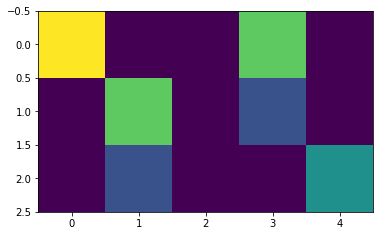

In [3]:
env = GridEnvironment(max_timesteps = 10)
obs = env.reset()
env.render()

""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Reward: 2, Action taken: right, Done: True


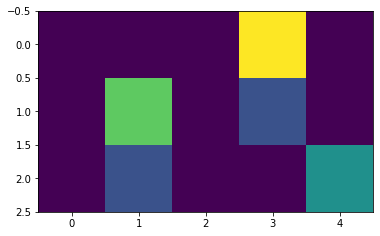

<IPython.core.display.Javascript object>

In [4]:
env.reset()
actions_given = []
rewards = []
observations = []
action_dict = {
    0: 'down',
    1: 'up',
    2: 'right',
    3: 'left',
}

output_grid = widgets.Grid(1,1)
for _ in range(10):
  action = np.random.randint(0,4)
  observation, reward, done, info = env.step(action)
  actions_given.append(action)
  rewards.append(reward)
  observations.append(observation)
  with output_grid.output_to(0,0):
    output_grid.clear_cell()
    env.render()
    print(f'Reward: {reward}, Action taken: {action_dict[action]}, Done: {done}')
  time.sleep(1)

In [5]:
actions_given

[0, 0, 3, 1, 1, 2, 0, 2, 1, 2]

In [6]:
rewards

[1, 1, 0, -1, -1, 1, 2, 1, -1, 2]

## Stochastic Environment

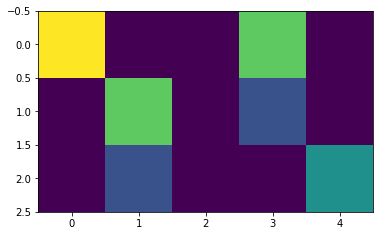

In [7]:
env = GridEnvironment(stochastic=True)
obs = env.reset()
env.render()

""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Reward: -1, Action given: left, Action taken: left


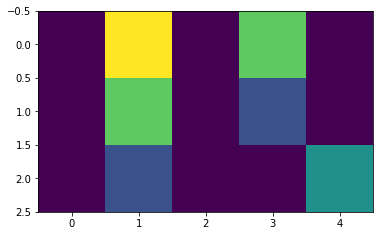

<IPython.core.display.Javascript object>

In [8]:
env.reset()
actions_given = []
actions_taken = []
rewards = []
observations = []
action_dict = {
    0: 'down',
    1: 'up',
    2: 'right',
    3: 'left',
}

output_grid = widgets.Grid(1,1)
for _ in range(10):
  action = np.random.randint(0,4)
  observation, reward, done, info = env.step(action)
  action_taken = info['action_taken']
  actions_given.append(action)
  actions_taken.append(action_taken)
  rewards.append(reward)
  observations.append(observation)
  with output_grid.output_to(0,0):
    output_grid.clear_cell()
    env.render()
    print(f'Reward: {reward}, Action given: {action_dict[action]}, Action taken: {action_dict[action_taken]}')
  time.sleep(1)

In [9]:
actions_given

[2, 2, 3, 2, 3, 2, 3, 2, 2, 3]

In [10]:
actions_taken

[2, 2, 3, 2, 3, 1, 3, 2, 2, 3]

In [11]:
rewards

[1, 1, -1, 1, -1, 0, -1, 1, 1, -1]

## Q-Learning

In [12]:
class QLearning:

    def __init__(self, env):

        self.env = env
        self.Q = np.zeros((env.observation_space.n, env.action_space.n))
        self.train_epsilons = []
        self.train_penalties = []
        self.train_rewards = []
        self.train_total_rewards = []

    def train(self, alpha=0.15, gamma = 0.9, episodes = 50):
        epsilon = 1 #set initial epsilon

        rate_of_decay = 10**(-4/episodes)

        t = trange(episodes)

        for i in t:

            state = self.env.reset()    #reset env

            self.env.seed(seed)

            state = 5*state[0]+state[1]

            done = False

            steps = 0
            penalties = 0
            rewards = 0
            total_reward = 0

            while not done:

                if np.random.uniform(0,1)<epsilon:               #Epsilon greedy policy for exploration strategy
                    action = self.env.action_space.sample()      #Explore
                else:
                    action = np.argmax(self.Q[state])            #Exploit

                next_state, reward, done, info = self.env.step(action)  #Do 1 step based on the action chosen

                next_state = 5*next_state[0]+next_state[1]              

                q_old = self.Q[state, action] 

                max_q_hat = np.max(self.Q[next_state])

                new_q = reward+gamma*max_q_hat

                new_q = (1-alpha)*q_old + alpha*new_q

                self.Q[state,action] = round(new_q,4)                            #Update Q-table

                state = next_state                                      #next state as current state

                if reward<0:
                    penalties+=1                                        #Store penalties
                
                rewards += pow(gamma, steps)*reward                     #Discounted reward calculation

                total_reward += reward

                steps += 1
            
            self.train_penalties.append(penalties)
            self.train_rewards.append(rewards)
            self.train_epsilons.append(epsilon)
            self.train_total_rewards.append(total_reward)

            t.set_postfix(epsilon = epsilon, reward=rewards, timesteps = steps, penalties = penalties)

            epsilon = rate_of_decay*epsilon

    def evaluate(self, gamma = 0.9):
        state = self.env.reset()
        self.env.seed(seed)
        state = 5*state[0]+state[1]

        steps = 0
        rewards = 0
        penalties = 0

        test_rewards = list()
        test_steps = list()
        test_total_reward = 0

        done = False

        while not done:

            action = np.argmax(self.Q[state])                       #Greedy choice
            state, reward, done, info = self.env.step(action)
            state = 5*state[0]+state[1]       

            if reward<0:
              penalties+=1

            rewards += pow(gamma, steps)*reward

            steps += 1
            
            test_total_reward += reward

            # print(self.env.timestep)

            steps += 1

            test_steps.append(action)
            
            test_rewards.append(rewards)

        test_penalties = penalties

        return penalties, test_rewards, test_steps, test_total_reward

### Non-Stochastic environment

In [13]:
env = GridEnvironment(max_timesteps = 10)
env.seed(50)
qlearning = QLearning(env=env)

In [14]:
qlearning.train(episodes = 600)

100%|██████████| 600/600 [00:03<00:00, 190.89it/s, epsilon=0.000102, penalties=0, reward=10.9, timesteps=6]


In [15]:
reslist = list()
for _ in range(10):
  res = qlearning.evaluate()
  env.reset()
  for i in range(len(res[2])):
    action = res[2][i]
    observation, reward, done, info = env.step(action)
    # with output_grid.output_to(0,0):
    #   output_grid.clear_cell()
    #   env.render()
    #   print(f'Reward: {reward}, Action given: {action_dict[action]}')
    # time.sleep(1)
  reslist.append(res[3])

In [16]:
print(f'penalties: {res[0]}')
print(f'reward per episode: {res[1]}')
print(f'steps: {res[2]}')
print(f'total reward: {res[3]}')

penalties: 0
reward per episode: [1.0, 2.62, 3.2761, 3.807541, 4.23800821, 7.724792611000002]
steps: [0, 2, 2, 0, 2, 2]
total reward: 16


Text(0, 0.5, 'Cumulative Reward')

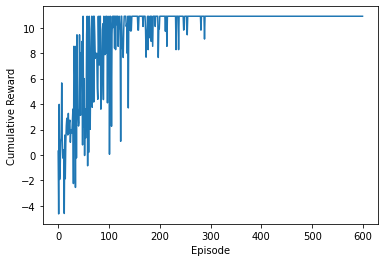

In [17]:
plt.plot(range(len(qlearning.train_rewards)), qlearning.train_rewards)
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')

Text(0, 0.5, 'Total Reward')

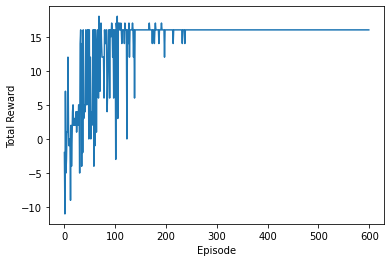

In [18]:
plt.plot(range(len(qlearning.train_total_rewards)), qlearning.train_total_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

Text(0, 0.5, 'Epsilon')

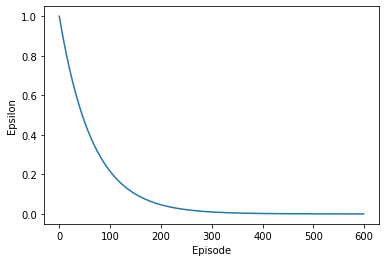

In [19]:
plt.plot(range(len(qlearning.train_epsilons)), qlearning.train_epsilons)
plt.xlabel('Episode')
plt.ylabel('Epsilon')

Text(0, 0.5, 'Reward')

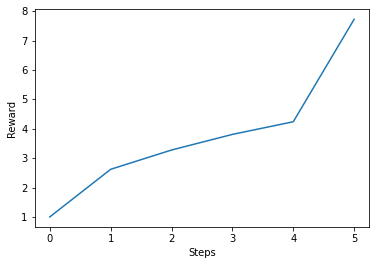

In [20]:
plt.plot(range(len(res[1])), res[1])
plt.xlabel('Steps')
plt.ylabel('Reward')

Text(0, 0.5, 'Total Reward')

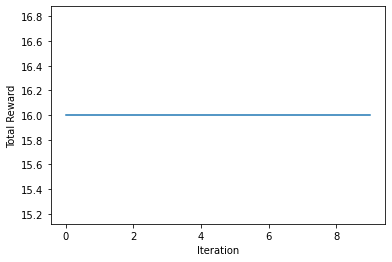

In [21]:
plt.plot(range(len(reslist)), reslist)
plt.xlabel('Iteration')
plt.ylabel('Total Reward')

### Stochastic environment

In [22]:
stoch_env = GridEnvironment(stochastic=True, max_timesteps = 10)
stoch_env.seed(seed)
qlearning_stochastic = QLearning(env=env)
qlearning_stochastic.train(episodes=600)

100%|██████████| 600/600 [00:02<00:00, 207.64it/s, epsilon=0.000102, penalties=0, reward=10.9, timesteps=6]


In [23]:
res = qlearning_stochastic.evaluate()

In [24]:
print(f'penalties: {res[0]}')
print(f'reward per episode: {res[1]}')
print(f'steps: {res[2]}')
print(f'total reward: {res[3]}')

penalties: 0
reward per episode: [1.0, 2.62, 3.2761, 3.807541, 4.23800821, 7.724792611000002]
steps: [2, 0, 2, 0, 2, 2]
total reward: 16


In [25]:
reslist = list()
for _ in range(10):
  res = qlearning_stochastic.evaluate()
  stoch_env.reset()
  for i in range(len(res[2])):
    action = res[2][i]
    observation, reward, done, info = stoch_env.step(action)
    # action_taken = info['action_taken']
    # with output_grid.output_to(0,0):
    #   output_grid.clear_cell()
    #   stoch_env.render()
    #   print(f'Reward: {reward}, Action given: {action_dict[action]}, Action taken: {action_dict[action_taken]}')
    # time.sleep(1)
  reslist.append(res[3])

Text(0, 0.5, 'Cumulative Reward')

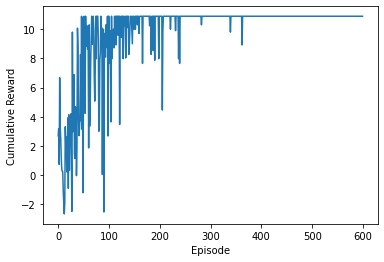

In [26]:
plt.plot(range(len(qlearning_stochastic.train_rewards)), qlearning_stochastic.train_rewards)
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')

Text(0, 0.5, 'Total Reward')

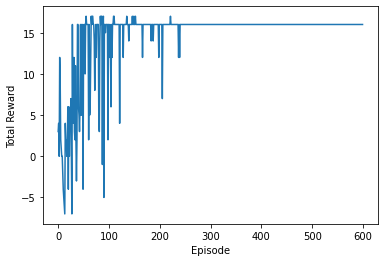

In [27]:
plt.plot(range(len(qlearning_stochastic.train_total_rewards)), qlearning_stochastic.train_total_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

Text(0, 0.5, 'Epsilon')

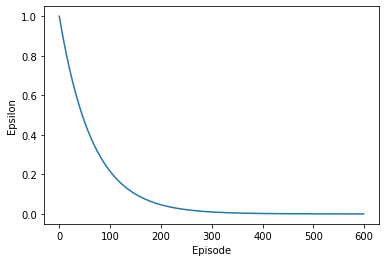

In [28]:
plt.plot(range(len(qlearning_stochastic.train_epsilons)), qlearning_stochastic.train_epsilons)
plt.xlabel('Episode')
plt.ylabel('Epsilon')

Text(0, 0.5, 'Reward')

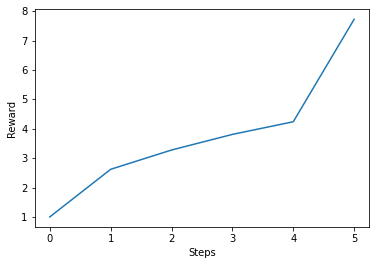

In [29]:
plt.plot(range(len(res[1])), res[1])
plt.xlabel('Steps')
plt.ylabel('Reward')

Text(0, 0.5, 'Total Reward')

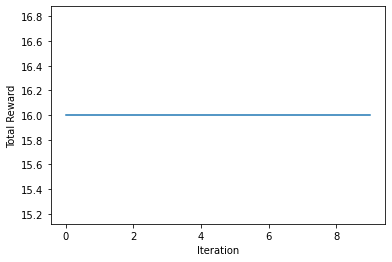

In [30]:
plt.plot(range(len(reslist)), reslist)
plt.xlabel('Iteration')
plt.ylabel('Total Reward')

## Double Q-Learning

In [31]:
class DoubleQLearning:

    def __init__(self, env):

        self.env = env
        self.Q1 = np.zeros((env.observation_space.n, env.action_space.n))
        self.Q2 = np.zeros((env.observation_space.n, env.action_space.n))
        self.train_epsilons = list()
        self.train_penalties = list()
        self.train_rewards = list()
        self.train_total_rewards = list()

    def train(self, alpha=0.15, gamma = 0.9, episodes = 50):
        epsilon = 1 #set initial epsilon

        rate_of_decay = 10**(-4/episodes)

        t = trange(episodes)

        for i in t:

            state = self.env.reset()    #reset env

            self.env.seed(seed)

            state = 5*state[0]+state[1]

            done = False

            steps = 0
            penalties = 0
            rewards = 0
            total_reward = 0

            while not done:
              if(np.random.uniform(0,1)<0.5):
                if np.random.uniform(0,1)<epsilon:               #Epsilon greedy policy for exploration strategy
                  action = self.env.action_space.sample()      #Explore

                else:
                  action = np.argmax(self.Q1[state])
                
                next_state, reward, done, info = self.env.step(action)  #Do 1 step based on the action chosen

                next_state = 5*next_state[0]+next_state[1]              

                q_old = self.Q1[state, action] 

                max_q_hat = np.max(self.Q2[next_state])

                new_q = reward+gamma*max_q_hat

                new_q = (1-alpha)*q_old + alpha*new_q

                self.Q1[state,action] = new_q                            #Update Q1-table

                state = next_state                                      #next state as current state

                if reward<0:
                  penalties+=1                                        #Store penalties
              
                rewards += pow(gamma, steps)*reward                     #Discounted reward calculation

                total_reward += reward

                steps += 1

              else:
                if np.random.uniform(0,1)<epsilon:               #Epsilon greedy policy for exploration strategy
                  action = self.env.action_space.sample()        #Explore

                else:
                  action = np.argmax(self.Q2[state])
                
                next_state, reward, done, info = self.env.step(action)  #Do 1 step based on the action chosen

                next_state = 5*next_state[0]+next_state[1]              

                q_old = self.Q2[state, action] 

                max_q_hat = np.max(self.Q1[next_state])

                new_q = reward+gamma*max_q_hat

                new_q = (1-alpha)*q_old + alpha*new_q

                self.Q2[state,action] = new_q                           #Update Q2-table

                state = next_state                                      #next state as current state

                if reward<0:
                  penalties+=1                                        #Store penalties
                
                rewards += pow(gamma, steps)*reward                     #Discounted reward calculation

                total_reward += reward

                steps += 1
            
            self.train_penalties.append(penalties)
            self.train_rewards.append(rewards)
            self.train_epsilons.append(epsilon)
            self.train_total_rewards.append(total_reward)

            t.set_postfix(epsilon = epsilon, reward=rewards, timesteps = steps, penalties = penalties)

            epsilon = rate_of_decay*epsilon

    def evaluate(self, table = 'Q1', gamma = 0.9):

        self.env.train = False
        state = self.env.reset()
        self.env.seed(seed)
        state = 5*state[0]+state[1]
        test_penalties = 0
        test_rewards = list()
        test_steps = list()
        test_total_reward = 0

        steps = 0
        rewards = 0
        penalties = 0

        done = False

        while not done:
            if(table=='Q2'):
              action = np.argmax(self.Q2[state])                       #Greedy choice
            elif(table=='Q1'):
              action = np.argmax(self.Q1[state])                       #Greedy choice
            else:
              print('Give correct input: {\'Q1\', \'Q2\'}')
            state, reward, done, info = self.env.step(action)  
            state = 5*state[0]+state[1]     

            if reward<0:
                    penalties+=1

            rewards += pow(gamma, steps)*reward

            test_total_reward += reward

            # print(self.env.timestep)

            steps += 1

            test_steps.append(action)
            
            test_rewards.append(rewards)

        test_penalties = penalties

        return penalties, test_rewards, test_steps, test_total_reward

### Non-Stochastic

In [32]:
new_env = GridEnvironment(max_timesteps = 10)
new_env.seed(seed)
dqlearning = DoubleQLearning(new_env)
dqlearning.__init__(new_env)
dqlearning.train(episodes = 600)

100%|██████████| 600/600 [00:03<00:00, 191.04it/s, epsilon=0.000102, penalties=0, reward=10.2, timesteps=7]


In [33]:
res = dqlearning.evaluate()

In [34]:
print(f'penalties: {res[0]}')
print(f'reward per episode: {res[1]}')
print(f'steps: {res[2]}')
print(f'total reward: {res[3]}')

penalties: 0
reward per episode: [1.0, 2.8, 3.61, 4.339, 4.995100000000001, 10.900000000000002]
steps: [0, 2, 2, 0, 2, 2]
total reward: 16


In [35]:
reslist = list()
for _ in range(10):
  res = dqlearning.evaluate()
  new_env.reset()
  for i in range(len(res[2])):
    action = res[2][i]
    observation, reward, done, info = new_env.step(action)
    # with output_grid.output_to(0,0):
    #   output_grid.clear_cell()
    #   new_env.render()
    #   print(f'Reward: {reward}, Action given: {action_dict[action]}, Done: {done}')
    # time.sleep(1)
  reslist.append(res[3])

Text(0, 0.5, 'Cumulative Reward')

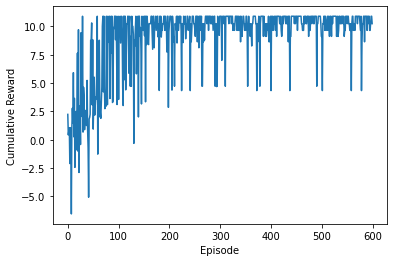

In [36]:
plt.plot(range(len(dqlearning.train_rewards)), dqlearning.train_rewards)
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')

Text(0, 0.5, 'Total Reward')

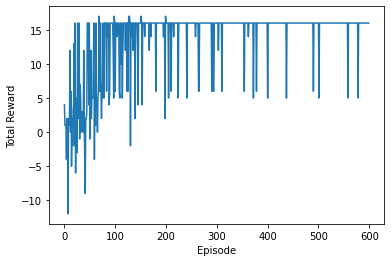

In [37]:
plt.plot(range(len(dqlearning.train_total_rewards)), dqlearning.train_total_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

Text(0, 0.5, 'Epsilon')

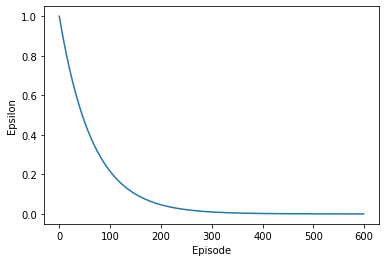

In [38]:
plt.plot(range(len(dqlearning.train_epsilons)), dqlearning.train_epsilons)
plt.xlabel('Episode')
plt.ylabel('Epsilon')


Text(0, 0.5, 'Reward')

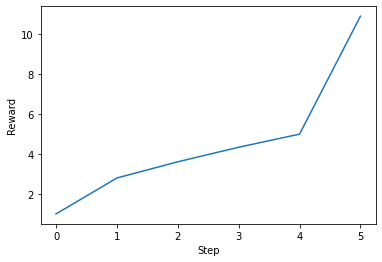

In [39]:
plt.plot(range(len(res[1])), res[1])
plt.xlabel('Step')
plt.ylabel('Reward')

Text(0, 0.5, 'Total Reward')

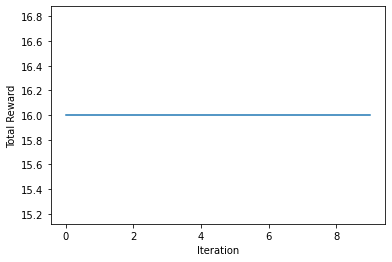

In [40]:
plt.plot(range(len(reslist)), reslist)
plt.xlabel('Iteration')
plt.ylabel('Total Reward')

### Stochastic

In [51]:
stoch_new_env = GridEnvironment(stochastic=True, max_timesteps = 10)
stoch_new_env.seed(seed)
dqlearning_stochastic = DoubleQLearning(env=stoch_new_env)
dqlearning_stochastic.__init__(stoch_new_env)
dqlearning_stochastic.train(episodes = 600)
res = dqlearning_stochastic.evaluate()

100%|██████████| 600/600 [00:03<00:00, 184.63it/s, epsilon=0.000102, penalties=0, reward=10.9, timesteps=6]


In [52]:
print(f'penalties: {res[0]}')
print(f'reward per episode: {res[1]}')
print(f'steps: {res[2]}')
print(f'total reward: {res[3]}')

penalties: 0
reward per episode: [1.0, 2.8, 3.61, 4.339, 4.995100000000001, 10.900000000000002]
steps: [2, 0, 2, 0, 2, 2]
total reward: 16


In [53]:
reslist = list()
for _ in range(10):
  res = dqlearning_stochastic.evaluate()
  stoch_new_env.reset()
  for i in range(len(res[2])):
    action = res[2][i]
    observation, reward, done, info = stoch_new_env.step(action)
    # with output_grid.output_to(0,0):
    #   output_grid.clear_cell()
    #   stoch_env.render()
    #   print(f'Reward: {reward}, Action given: {action_dict[action]}')
    # time.sleep(1)
  reslist.append(res[3])

Text(0, 0.5, 'Cumulative Reward')

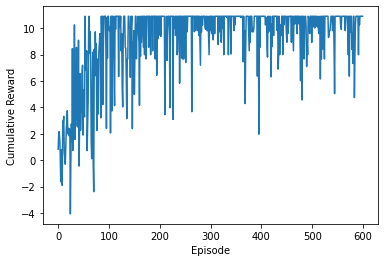

In [54]:
plt.plot(range(len(dqlearning_stochastic.train_rewards)), dqlearning_stochastic.train_rewards)
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')

Text(0, 0.5, 'Total Reward')

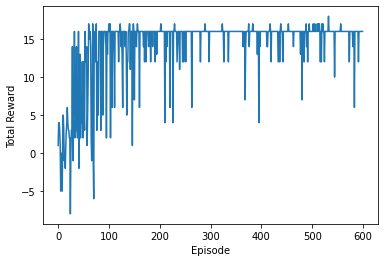

In [55]:
plt.plot(range(len(dqlearning_stochastic.train_total_rewards)), dqlearning_stochastic.train_total_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

Text(0, 0.5, 'Epsilon')

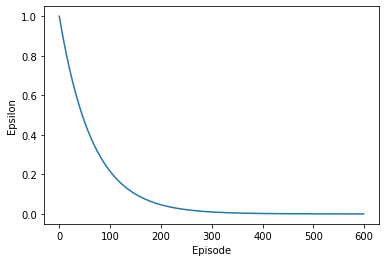

In [56]:
plt.plot(range(len(dqlearning_stochastic.train_epsilons)), dqlearning_stochastic.train_epsilons)
plt.xlabel('Episode')
plt.ylabel('Epsilon')

Text(0, 0.5, 'Reward')

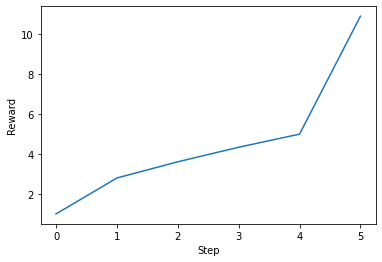

In [57]:
plt.plot(range(len(res[1])), res[1])
plt.xlabel('Step')
plt.ylabel('Reward')

Text(0, 0.5, 'Total Reward')

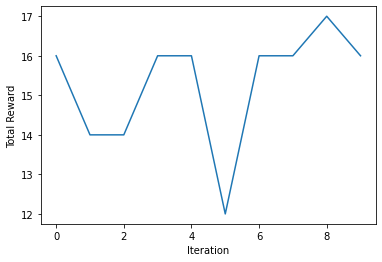

In [58]:
plt.plot(range(len(reslist)), reslist)
plt.xlabel('Iteration')
plt.ylabel('Total Reward')

## Q-learning vs Double Q-learning

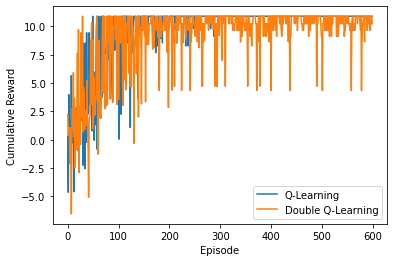

In [49]:
plt.plot(range(len(qlearning.train_rewards)), qlearning.train_rewards, label = 'Q-Learning')
plt.plot(range(len(dqlearning.train_rewards)), dqlearning.train_rewards, label = 'Double Q-Learning')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.legend()

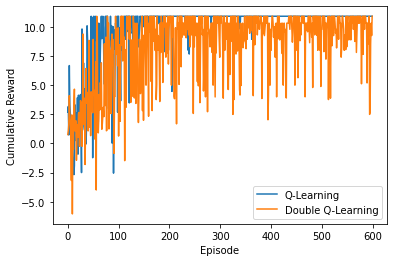

In [50]:
plt.plot(range(len(qlearning_stochastic.train_rewards)), qlearning_stochastic.train_rewards, label = 'Q-Learning')
plt.plot(range(len(dqlearning_stochastic.train_rewards)), dqlearning_stochastic.train_rewards, label = 'Double Q-Learning')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.legend()